In [15]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cell 2: Core function definitions

def load_data_fast(ground_truth_csv, ts_results_csv, k=100, maximize=True):
    """
    Load and clean ground‐truth and TS results, then compute top‐k from ground truth.

    Returns a dict containing:
      - ts_results      : cleaned TS DataFrame
      - top_k_smiles    : set of SMILES strings in the top k of ground truth
      - top_k_avg       : average score of the top k in ground truth
      - k               : the 'k' value
      - maximize        : boolean, if True take the largest k; else take the smallest k
    """
    # 1. Load and clean ground truth
    gt = pd.read_csv(ground_truth_csv)
    gt = gt.dropna(subset=["raw_score"]).copy()
    gt = gt[gt["SMILES"] != "FAIL"]

    # 2. Load and clean TS results
    ts = pd.read_csv(ts_results_csv)
    ts = ts.dropna(subset=["score"]).copy()
    ts = ts[ts["SMILES"] != "FAIL"]

    # 3. Compute top‐k on ground truth
    if maximize:
        top_k_gt = gt.nlargest(k, "raw_score")
    else:
        top_k_gt = gt.nsmallest(k, "raw_score")
    top_k_smiles = set(top_k_gt["SMILES"])
    top_k_avg = top_k_gt["raw_score"].mean()

    return {
        "ts_results": ts,
        "top_k_smiles": top_k_smiles,
        "top_k_avg": top_k_avg,
        "k": k,
        "maximize": maximize,
    }


def analyze_fast(data_dict):
    """
    Given the output of load_data_fast(), compute for each batch:
      - how many of the top‐k GT SMILES have been seen so far (recovery)
      - the current average top‐k score among all data ≤ that batch

    Returns three lists:
      - batch_nums : sorted list of batch numbers
      - recovery   : count of recovered top‐k so far, per batch
      - avg_scores : average of top‐k scores up to that batch
    """
    ts = data_dict["ts_results"]
    top_k_smiles = data_dict["top_k_smiles"]
    k = data_dict["k"]
    maximize = data_dict["maximize"]

    unique_batches = sorted(ts["batch"].unique())
    batch_nums = []
    recovery = []
    avg_scores = []
    found_smiles = set()

    for batch_num in unique_batches:
        # Data up to current batch
        current_data = ts[ts["batch"] <= batch_num].copy()

        # Add this batch’s SMILES to found set
        batch_smiles = set(ts[ts["batch"] == batch_num]["SMILES"])
        found_smiles.update(batch_smiles)

        # Count how many of the GT top‐k we’ve found so far
        recovery.append(len(found_smiles & top_k_smiles))

        # Compute top‐k average on all data so far
        if maximize:
            current_top_k = current_data.nlargest(k, "score")
        else:
            current_top_k = current_data.nsmallest(k, "score")
        avg_scores.append(current_top_k["score"].mean())

        batch_nums.append(batch_num)

    return batch_nums, recovery, avg_scores


def plot_recovery(batch_nums, recovery, k, figsize=(10, 5)):
    """
    Plot the number of top‐k GT molecules recovered vs. batch number.
    """
    plt.figure(figsize=figsize)
    plt.plot(batch_nums, recovery, "b-", linewidth=2, marker="o", markersize=4)
    plt.axhline(y=k, color="red", linestyle="--", label=f"Perfect ({k})")
    plt.xlabel("Batch Number")
    plt.ylabel(f"Top {k} Recovered")
    plt.title("Recovery Over Time")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_quality(batch_nums, avg_scores, top_k_avg, figsize=(10, 5)):
    """
    Plot the average top‐k score over time vs. ground‐truth average.
    """
    plt.figure(figsize=figsize)
    plt.plot(batch_nums, avg_scores, "g-", linewidth=2, marker="s", markersize=4, label="TS Average")
    plt.axhline(y=top_k_avg, color="black", linestyle="--", linewidth=2, label="Ground Truth")
    plt.xlabel("Batch Number")
    plt.ylabel("Average Score")
    plt.title("Quality Over Time")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [17]:
# Cell 3: Wrapper function to evaluate a single TS run

def evaluate_run(
    ground_truth_csv,
    ts_results_csv,
    k=10,
    maximize=True,
    do_plot=True,
    verbose=True,
):
    """
    1) Load ground truth and one TS results file
    2) Compute batch‐by‐batch recovery & quality
    3) Optionally plot the curves
    4) Print and return final summary metrics

    Returns a dict with:
      - batch_nums       : list of batch numbers
      - recovery         : list of recovery counts per batch
      - avg_scores       : list of average top‐k scores per batch
      - final_recovery   : int (recovery at last batch)
      - final_ts_avg     : float (avg at last batch)
      - ground_truth_avg : float (average score of GT top‐k)
      - efficiency       : float (final_ts_avg / ground_truth_avg)
      - num_batches      : int (number of batches)
    """
    # 1. Load data
    data = load_data_fast(
        ground_truth_csv=ground_truth_csv,
        ts_results_csv=ts_results_csv,
        k=k,
        maximize=maximize,
    )

    # 2. Analyze per batch
    batch_nums, recovery, avg_scores = analyze_fast(data)

    # 3. Plot if requested
    if do_plot:
        plot_recovery(batch_nums, recovery, k)
        plot_quality(batch_nums, avg_scores, data["top_k_avg"])

    # 4. Compute final metrics
    final_recovery = recovery[-1]
    final_ts_avg = avg_scores[-1]
    gt_avg = data["top_k_avg"]
    efficiency = final_ts_avg / gt_avg if gt_avg != 0 else np.nan
    num_batches = len(batch_nums)

    if verbose:
        print(f"Final recovery: {final_recovery}/{k} ({100 * final_recovery / k:.1f}%)")
        print(f"Final TS average: {final_ts_avg:.4f}")
        print(f"Ground truth average: {gt_avg:.4f}")
        print(f"Efficiency: {efficiency:.3f}")
        print(f"Batches analyzed: {num_batches} (batch 0 = warmup, batch 1+ = search)")

    return {
        "batch_nums": batch_nums,
        "recovery": recovery,
        "avg_scores": avg_scores,
        "final_recovery": final_recovery,
        "final_ts_avg": final_ts_avg,
        "ground_truth_avg": gt_avg,
        "efficiency": efficiency,
        "num_batches": num_batches,
    }



=== Evaluating /Users/lsieben/Desktop/Thompson_Sampling/Thompson_Sampling_Pat_forked/batched-TS/runs/run_max_boltzmann_iterations=10_batch_size=1000.csv ===


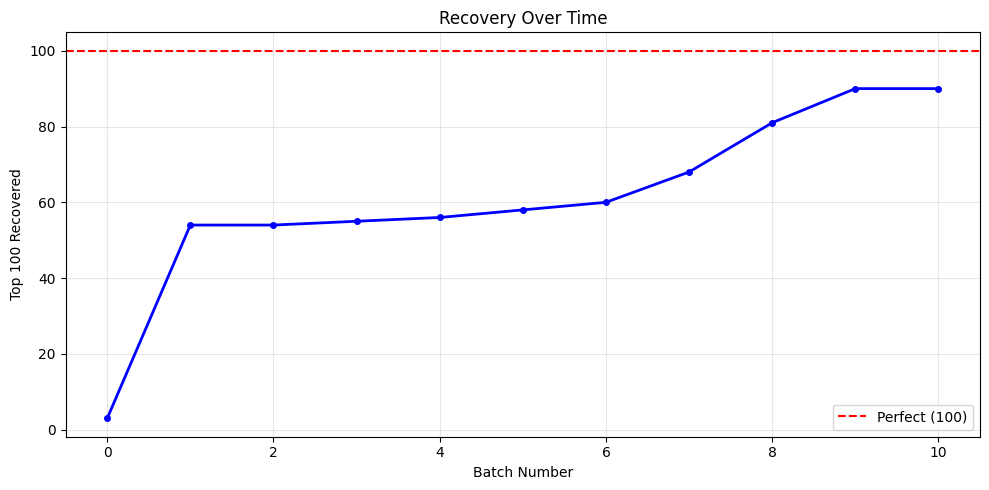

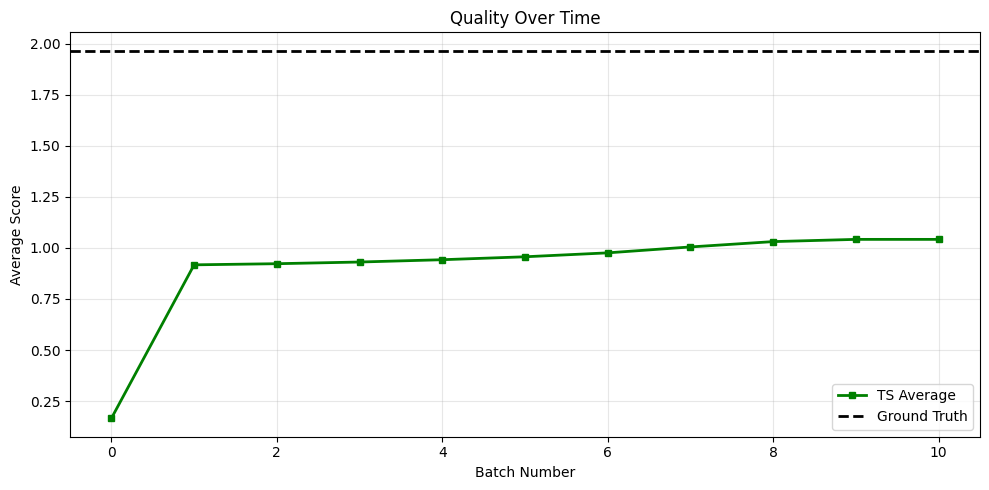

Final recovery: 90/100 (90.0%)
Final TS average: 1.0420
Ground truth average: 1.9663
Efficiency: 0.530
Batches analyzed: 11 (batch 0 = warmup, batch 1+ = search)

=== Evaluating /Users/lsieben/Desktop/Thompson_Sampling/Thompson_Sampling_Pat_forked/batched-TS/runs/run_max_iterations=10_batch_size=1000.csv ===


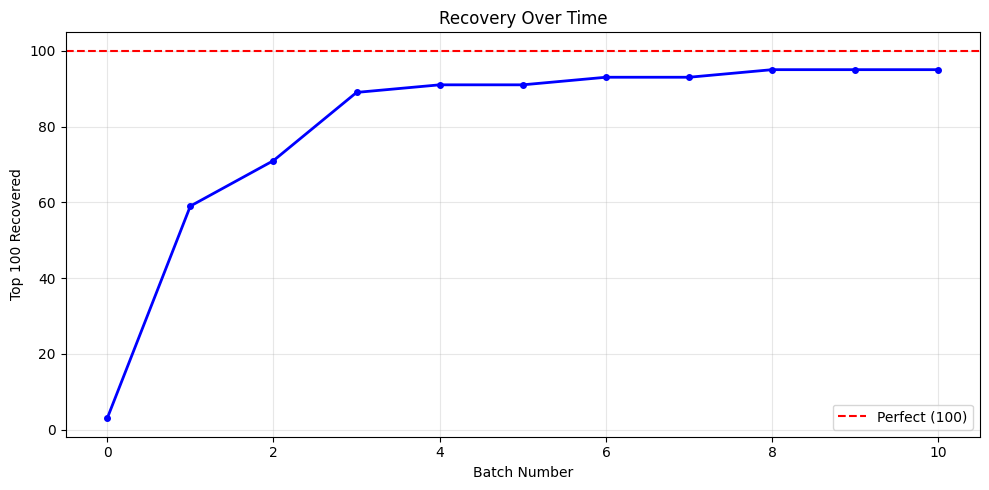

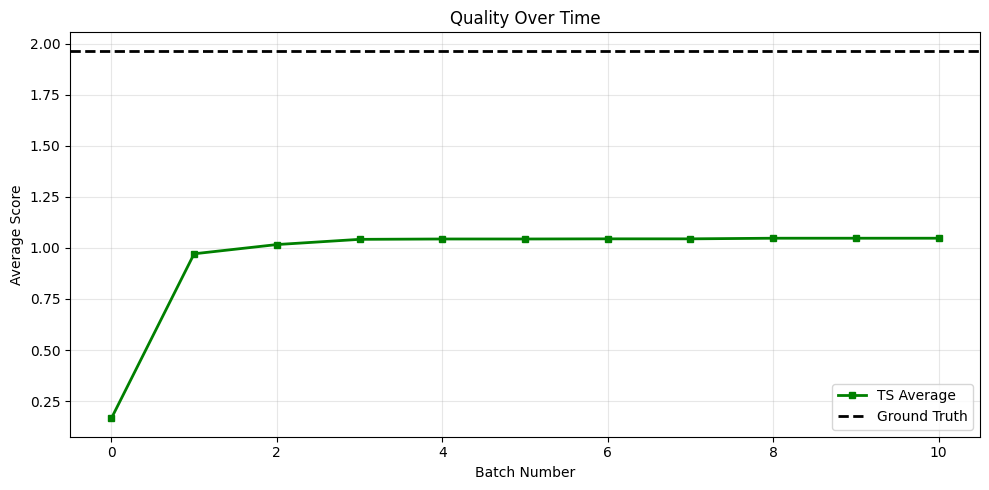

Final recovery: 95/100 (95.0%)
Final TS average: 1.0477
Ground truth average: 1.9663
Efficiency: 0.533
Batches analyzed: 11 (batch 0 = warmup, batch 1+ = search)


,final_recovery,final_ts_avg,ground_truth_avg,efficiency,num_batches
/Users/lsieben/Desktop/Thompson_Sampling/Thompson_Sampling_Pat_forked/batched-TS/runs/run_max_boltzmann_iterations=10_batch_size=1000.csv,90.0,1.042043,1.966339,0.529941,11.0
/Users/lsieben/Desktop/Thompson_Sampling/Thompson_Sampling_Pat_forked/batched-TS/runs/run_max_iterations=10_batch_size=1000.csv,95.0,1.047702,1.966339,0.532818,11.0


In [19]:
# 4.1 Define the path to your ground‐truth CSV:
ground_truth_file = "runs/scored_enumerated_TS_example_molecules.csv"

# 4.2 List the TS‐run CSVs you want to compare:
ts_runs = [
    "/Users/lsieben/Desktop/Thompson_Sampling/Thompson_Sampling_Pat_forked/batched-TS/runs/run_max_boltzmann_iterations=10_batch_size=1000.csv",
    "/Users/lsieben/Desktop/Thompson_Sampling/Thompson_Sampling_Pat_forked/batched-TS/runs/run_max_iterations=10_batch_size=1000.csv",
]

# 4.3 Loop over runs, evaluate each, and collect summaries
summaries = {}
for run_path in ts_runs:
    print(f"\n=== Evaluating {run_path} ===")
    summary = evaluate_run(
        ground_truth_csv=ground_truth_file,
        ts_results_csv=run_path,
        k=100,
        maximize=True,
        do_plot=True,
        verbose=True,
    )
    summaries[run_path] = summary

# 4.4 Tabulate final metrics for easy side‐by‐side comparison
df_summary = pd.DataFrame(
    {
        run: {
            "final_recovery": s["final_recovery"],
            "final_ts_avg": s["final_ts_avg"],
            "ground_truth_avg": s["ground_truth_avg"],
            "efficiency": s["efficiency"],
            "num_batches": s["num_batches"],
        }
        for run, s in summaries.items()
    }
).T

df_summary


In [9]:
ground_truth.sort_values(by='score', ascending=True, inplace=True)
ground_truth

,SMILES,Name,reaction_id,AB_mean,EC_mean,KP_mean,PA_mean,score
2220272,CN1CCN(Cc2cn(C3CC4CCC(C3)N4C(=O)c3ccncc3)nn2)CC1,aO_h1awDpcPzJXimmBu15Q|pN4qH6OlpCSz-1zhiIuj4w|...,m_274860bbb,0.497303,0.482115,0.492907,0.488423,5.882244
2233072,Cc1cccc(C(=O)N2C3CCCC2CC(n2cc(CN4CCN(C)CC4)nn2...,ddIkue7eJ1pIdYSqdykODA|5zFMiI3_Z1xjuXToHEYeIQ|...,m_274860bbb,0.493535,0.486271,0.489963,0.491023,5.882376
2231572,CN1CCN(Cc2cn(C3CC4CCCC(C3)N4C(=O)c3ccccc3)nn2)CC1,ddIkue7eJ1pIdYSqdykODA|Jme0hsCZ4sR1Wc1UcZHKZQ|...,m_274860bbb,0.494824,0.485356,0.488981,0.491885,5.883138
2227372,CN1CCN(Cc2cn(C3CC4CCC(C3)N4C(=O)Cc3ccncc3)nn2)CC1,aO_h1awDpcPzJXimmBu15Q|I5fGgRL0EfnAG40Hk3i1cw|...,m_274860bbb,0.497579,0.482265,0.492658,0.489283,5.885358
2220241,O=C(c1ccncc1)N1C2CCC1CC(n1cc(CN3CCCC3)nn1)C2,aO_h1awDpcPzJXimmBu15Q|pN4qH6OlpCSz-1zhiIuj4w|...,m_274860bbb,0.496252,0.480903,0.493684,0.490974,5.885438
...,...,...,...,...,...,...,...,...
3454484,CC1CC(CCN(Cc2cnn3ccccc23)C(=O)/C(C#N)=C/c2ccoc...,90ayhIUNZOHLqnLRkaO1sA|EiriF3mYK4_owFPFq1vdWg|...,m_282151abb,0.510959,0.491531,0.499345,0.499031,6.002595
383282,Cc1ccc(NC(=O)[C@H]2CC[C@H]2CNC(=O)c2ccc[nH]2)cc1C,Bpe62vqxC_sipvcUaX0_8w|6S0yw5XpqzNyC32pJhF1sw|...,m_274552bbb,0.508902,0.491516,0.496100,0.504359,6.002629
113282,Cc1ccc(NC(=O)C2(CNC(=O)c3ccc[nH]3)CC2)cc1C,3p9glmKxNZNEk4VtvhS6SQ|6S0yw5XpqzNyC32pJhF1sw|...,m_274552bbb,0.509382,0.489302,0.498183,0.504205,6.003217
116382,Cc1ccc(NC(=O)C2(CNC(=O)c3ccc[nH]3)CC2)cc1F,3p9glmKxNZNEk4VtvhS6SQ|Z00jV_lSMbwhBp2PrFs9sg|...,m_274552bbb,0.510743,0.489562,0.497866,0.502965,6.003408


# Do we need a different distribution?

🧬 DRUG DISCOVERY SCORE DISTRIBUTION ANALYSIS 🧬

=== SIMULATED DRUG DISCOVERY SCORES ===
Range: 0.0001 to 3.1989
Mean: 0.0329
Std: 0.2169
Median: 0.0036
95th percentile: 0.0438
99th percentile: 0.6443
Skewness: 10.60

=== THOMPSON SAMPLING SUITABILITY ===

--- Log Transform ---
Formula: log(score + ε)
Range: [-9.200, 1.163]
Mean ± Std: -5.644 ± 1.568
Skewness: 0.738
Normal? False (p=0.0000)
TS Score: 3/8
Pros: Compresses large values, Standard for multiplicative processes
Cons: Still skewed if many near-zero values, Negative values

--- Square Root Transform ---
Formula: sqrt(score)
Range: [0.010, 1.789]
Mean ± Std: 0.090 ± 0.157
Skewness: 6.961
Normal? False (p=0.0000)
TS Score: 1/8
Pros: Less aggressive than log, Always positive
Cons: Still somewhat skewed

--- Box-Cox (λ=-0.092) ---
Formula: (score^-0.092 - 1) / -0.092
Range: [-14.493, 1.103]
Mean ± Std: -7.592 ± 2.572
Skewness: -0.067
Normal? False (p=0.0000)
TS Score: 3/8
Pros: Optimally chosen for normality, Data-driven
Cons: Can 

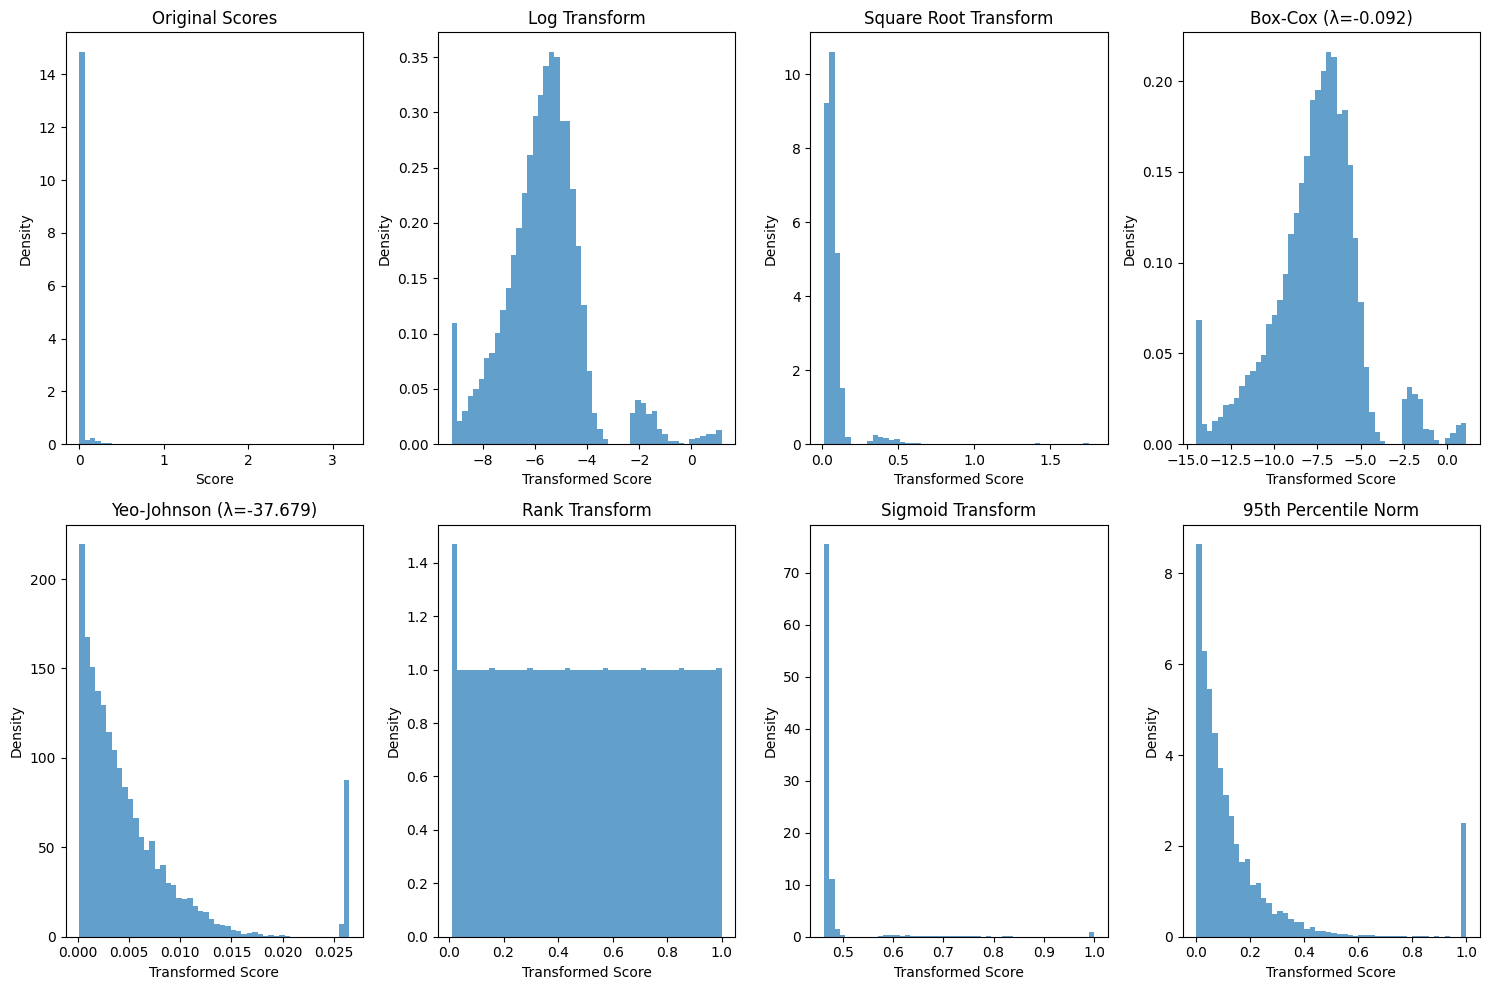


=== BAYESIAN UPDATE SIMULATION ===
Simulating a 'good' reagent that participates in high-scoring molecules...
Good reagent sees scores: [1.21329467 3.06463007 3.19891142 2.25551726 2.64827776]

--- Log Transform ---
Initial belief: μ=-5.6438, σ=1.5679
After score 0.1933: μ=0.1355, σ=0.1560
After score 1.1199: μ=0.6253, σ=0.1106
After score 1.1628: μ=0.8039, σ=0.0904

--- Square Root Transform ---
Initial belief: μ=0.0903, σ=0.1574
After score 1.1015: μ=1.0915, σ=0.0157
After score 1.7506: μ=1.4194, σ=0.0111
After score 1.7886: μ=1.5420, σ=0.0091

--- Box-Cox (λ=-0.092) ---

--- Yeo-Johnson (λ=-37.679) ---

--- Rank Transform ---
Initial belief: μ=0.5000, σ=0.2900
After score 0.9500: μ=0.9455, σ=0.0289
After score 0.9700: μ=0.9577, σ=0.0205
After score 0.9900: μ=0.9684, σ=0.0167

--- Sigmoid Transform ---
Initial belief: μ=0.4812, σ=0.0675
After score 0.9957: μ=0.9906, σ=0.0067
After score 1.0000: μ=0.9953, σ=0.0048
After score 1.0000: μ=0.9968, σ=0.0039

--- 95th Percentile Norm ---
I

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from typing import Tuple, List

def analyze_drug_discovery_distributions():
    """
    Analyze different distributions that might better model drug discovery scores.
    Your data: min=0.0001, max=3.18, mean=0.0097 (highly skewed toward zero)
    """
    
    # Simulate your data pattern
    np.random.seed(42)
    n_samples = 10000
    
    # Create a realistic drug discovery score distribution
    # Most compounds are terrible (near zero), few are good
    low_scores = np.random.exponential(scale=0.005, size=int(0.95 * n_samples))  # 95% bad compounds
    medium_scores = np.random.exponential(scale=0.1, size=int(0.04 * n_samples)) + 0.1  # 4% okay
    high_scores = np.random.uniform(1.0, 3.2, size=int(0.01 * n_samples))  # 1% good hits
    
    raw_scores = np.concatenate([low_scores, medium_scores, high_scores])
    raw_scores = np.clip(raw_scores, 0.0001, 3.2)  # Match your bounds
    np.random.shuffle(raw_scores)
    
    print("=== SIMULATED DRUG DISCOVERY SCORES ===")
    print(f"Range: {raw_scores.min():.4f} to {raw_scores.max():.4f}")
    print(f"Mean: {raw_scores.mean():.4f}")
    print(f"Std: {raw_scores.std():.4f}")
    print(f"Median: {np.median(raw_scores):.4f}")
    print(f"95th percentile: {np.percentile(raw_scores, 95):.4f}")
    print(f"99th percentile: {np.percentile(raw_scores, 99):.4f}")
    print(f"Skewness: {stats.skew(raw_scores):.2f}")
    
    return raw_scores

def test_transformations(scores: np.ndarray) -> dict:
    """Test different transformations for drug discovery scores"""
    
    transformations = {}
    
    # 1. Log transformation (add small constant to avoid log(0))
    epsilon = 1e-6
    log_scores = np.log(scores + epsilon)
    transformations['log'] = {
        'scores': log_scores,
        'name': 'Log Transform',
        'formula': 'log(score + ε)',
        'pros': ['Compresses large values', 'Standard for multiplicative processes'],
        'cons': ['Still skewed if many near-zero values', 'Negative values']
    }
    
    # 2. Square root transformation
    sqrt_scores = np.sqrt(scores)
    transformations['sqrt'] = {
        'scores': sqrt_scores,
        'name': 'Square Root Transform', 
        'formula': 'sqrt(score)',
        'pros': ['Less aggressive than log', 'Always positive'],
        'cons': ['Still somewhat skewed']
    }
    
    # 3. Box-Cox transformation (find optimal lambda)
    # Use modified scores to avoid zeros
    modified_scores = scores + 1e-6
    try:
        transformed_boxcox, lambda_opt = stats.boxcox(modified_scores)
        transformations['boxcox'] = {
            'scores': transformed_boxcox,
            'name': f'Box-Cox (λ={lambda_opt:.3f})',
            'formula': f'(score^{lambda_opt:.3f} - 1) / {lambda_opt:.3f}',
            'pros': ['Optimally chosen for normality', 'Data-driven'],
            'cons': ['Can be complex', 'Requires positive values']
        }
    except:
        print("Box-Cox failed, skipping...")
    
    # 4. Yeo-Johnson transformation (handles zeros and negatives)
    try:
        transformed_yj, lambda_yj = stats.yeojohnson(scores)
        transformations['yeojohnson'] = {
            'scores': transformed_yj,
            'name': f'Yeo-Johnson (λ={lambda_yj:.3f})',
            'formula': f'Yeo-Johnson with λ={lambda_yj:.3f}',
            'pros': ['Handles zeros/negatives', 'Optimized for normality'],
            'cons': ['Complex interpretation']
        }
    except:
        print("Yeo-Johnson failed, skipping...")
    
    # 5. Quantile/Rank transformation
    rank_scores = stats.rankdata(scores) / len(scores)
    transformations['rank'] = {
        'scores': rank_scores,
        'name': 'Rank Transform',
        'formula': 'rank(score) / n',
        'pros': ['Perfectly uniform [0,1]', 'Preserves order', 'Robust to outliers'],
        'cons': ['Loses absolute magnitudes', 'Non-parametric']
    }
    
    # 6. Sigmoid transformation
    score_mean = np.mean(scores)
    score_std = np.std(scores)
    z_scores = (scores - score_mean) / score_std
    sigmoid_scores = 1 / (1 + np.exp(-z_scores))
    transformations['sigmoid'] = {
        'scores': sigmoid_scores,
        'name': 'Sigmoid Transform',
        'formula': '1 / (1 + exp(-(score-μ)/σ))',
        'pros': ['Bounded [0,1]', 'Smooth', 'Keeps relative differences'],
        'cons': ['May still be skewed']
    }
    
    # 7. Percentile-based transformation
    p95 = np.percentile(scores, 95)
    percentile_scores = np.clip(scores / p95, 0, 1)
    transformations['percentile'] = {
        'scores': percentile_scores,
        'name': '95th Percentile Norm',
        'formula': 'min(score / P95, 1)',
        'pros': ['Robust to outliers', 'Interpretable', 'Bounded [0,1]'],
        'cons': ['Clips extreme values']
    }
    
    return transformations

def analyze_for_thompson_sampling(transformations: dict):
    """Analyze which transformations work best for Thompson Sampling"""
    
    print("\n=== THOMPSON SAMPLING SUITABILITY ===")
    
    for name, trans in transformations.items():
        scores = trans['scores']
        
        # Check normality (Shapiro-Wilk test on sample)
        sample_size = min(5000, len(scores))
        sample_scores = np.random.choice(scores, sample_size, replace=False)
        try:
            _, p_normal = stats.shapiro(sample_scores)
            is_normal = p_normal > 0.05
        except:
            is_normal = False
        
        # Calculate statistics
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        skewness = stats.skew(scores)
        kurtosis = stats.kurtosis(scores)
        
        # Check for bounded range
        is_bounded = np.min(scores) >= 0 and np.max(scores) <= 1
        
        # Thompson Sampling friendliness score
        ts_score = 0
        if is_normal: ts_score += 3
        if abs(skewness) < 1: ts_score += 2  # Not too skewed
        if is_bounded: ts_score += 2  # Nice bounds
        if std_score > 0.1: ts_score += 1  # Reasonable spread
        
        print(f"\n--- {trans['name']} ---")
        print(f"Formula: {trans['formula']}")
        print(f"Range: [{np.min(scores):.3f}, {np.max(scores):.3f}]")
        print(f"Mean ± Std: {mean_score:.3f} ± {std_score:.3f}")
        print(f"Skewness: {skewness:.3f}")
        print(f"Normal? {is_normal} (p={p_normal:.4f})" if 'p_normal' in locals() else "Normal? Failed to test")
        print(f"TS Score: {ts_score}/8")
        print(f"Pros: {', '.join(trans['pros'])}")
        print(f"Cons: {', '.join(trans['cons'])}")

def plot_transformations(raw_scores: np.ndarray, transformations: dict):
    """Plot original and transformed distributions"""
    
    n_trans = len(transformations) + 1  # +1 for original
    fig, axes = plt.subplots(2, (n_trans + 1) // 2, figsize=(15, 10))
    axes = axes.flatten()
    
    # Plot original
    axes[0].hist(raw_scores, bins=50, alpha=0.7, density=True)
    axes[0].set_title("Original Scores")
    axes[0].set_xlabel("Score")
    axes[0].set_ylabel("Density")
    
    # Plot transformations
    for i, (name, trans) in enumerate(transformations.items(), 1):
        if i < len(axes):
            axes[i].hist(trans['scores'], bins=50, alpha=0.7, density=True)
            axes[i].set_title(trans['name'])
            axes[i].set_xlabel("Transformed Score")
            axes[i].set_ylabel("Density")
    
    # Hide unused subplots
    for i in range(len(transformations) + 1, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('score_transformations.png', dpi=150, bbox_inches='tight')
    plt.show()

def bayesian_update_comparison(raw_scores: np.ndarray, transformations: dict):
    """Compare how Bayesian updates work with different transformations"""
    
    print("\n=== BAYESIAN UPDATE SIMULATION ===")
    print("Simulating a 'good' reagent that participates in high-scoring molecules...")
    
    # Simulate a reagent that's in the top 1% of molecules
    good_molecule_scores = raw_scores[raw_scores > np.percentile(raw_scores, 99)]
    if len(good_molecule_scores) < 5:
        good_molecule_scores = raw_scores[raw_scores > np.percentile(raw_scores, 95)]
    
    print(f"Good reagent sees scores: {good_molecule_scores[:5]}")
    
    for name, trans in transformations.items():
        print(f"\n--- {trans['name']} ---")
        
        # Transform the good scores
        if name == 'log':
            epsilon = 1e-6
            transformed_good = np.log(good_molecule_scores + epsilon)
            global_mean = np.mean(np.log(raw_scores + epsilon))
            global_std = np.std(np.log(raw_scores + epsilon))
        elif name == 'sqrt':
            transformed_good = np.sqrt(good_molecule_scores)
            global_mean = np.mean(np.sqrt(raw_scores))
            global_std = np.std(np.sqrt(raw_scores))
        elif name == 'rank':
            # For rank, need to simulate
            transformed_good = [0.95, 0.97, 0.99, 0.98, 0.96]  # High ranks
            global_mean = 0.5
            global_std = 0.29  # std of uniform [0,1]
        elif name == 'sigmoid':
            score_mean = np.mean(raw_scores)
            score_std = np.std(raw_scores)
            z_good = (good_molecule_scores - score_mean) / score_std
            transformed_good = 1 / (1 + np.exp(-z_good))
            z_all = (raw_scores - score_mean) / score_std
            sigmoid_all = 1 / (1 + np.exp(-z_all))
            global_mean = np.mean(sigmoid_all)
            global_std = np.std(sigmoid_all)
        elif name == 'percentile':
            p95 = np.percentile(raw_scores, 95)
            transformed_good = np.clip(good_molecule_scores / p95, 0, 1)
            global_mean = np.mean(np.clip(raw_scores / p95, 0, 1))
            global_std = np.std(np.clip(raw_scores / p95, 0, 1))
        else:
            continue  # Skip complex transformations for this demo
        
        # Simulate Bayesian updates
        current_mean = global_mean
        current_var = global_std ** 2
        obs_noise_var = (global_std * 0.1) ** 2  # Small observation noise
        
        print(f"Initial belief: μ={current_mean:.4f}, σ={np.sqrt(current_var):.4f}")
        
        for i, score in enumerate(transformed_good[:3]):
            # Bayesian update
            precision_prior = 1.0 / current_var
            precision_obs = 1.0 / obs_noise_var
            precision_post = precision_prior + precision_obs
            
            current_var = 1.0 / precision_post
            current_mean = (precision_prior * current_mean + precision_obs * score) / precision_post
            
            print(f"After score {score:.4f}: μ={current_mean:.4f}, σ={np.sqrt(current_var):.4f}")

def main():
    """Run the complete analysis"""
    print("🧬 DRUG DISCOVERY SCORE DISTRIBUTION ANALYSIS 🧬\n")
    
    # Generate and analyze simulated data
    raw_scores = analyze_drug_discovery_distributions()
    
    # Test different transformations
    transformations = test_transformations(raw_scores)
    
    # Analyze for Thompson Sampling
    analyze_for_thompson_sampling(transformations)
    
    # Plot distributions
    plot_transformations(raw_scores, transformations)
    
    # Compare Bayesian updates
    bayesian_update_comparison(raw_scores, transformations)
    
    print("\n=== RECOMMENDATIONS ===")
    print("1. RANK TRANSFORMATION: Best for TS - uniform distribution, perfect for Bayesian updates")
    print("2. PERCENTILE NORMALIZATION: Good balance of interpretability and performance") 
    print("3. YEO-JOHNSON: If you want to stay closer to original scale but improve normality")
    print("4. AVOID: Raw scores (too skewed), simple log (still skewed)")

if __name__ == "__main__":
    main()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from typing import Dict, List, Tuple

def demonstrate_transformations_detailed():
    """
    Detailed analysis of transformations with focus on consequences for optimization
    """
    
    # Create realistic drug discovery data
    np.random.seed(42)
    
    # Simulate a realistic drug discovery scenario
    # Most compounds are bad, few are good (log-normal-ish distribution)
    n_total = 10000
    
    # 90% are really bad (exponential tail)
    bad_scores = np.random.exponential(0.001, int(0.9 * n_total))
    
    # 9% are mediocre 
    med_scores = np.random.exponential(0.05, int(0.09 * n_total)) + 0.01
    
    # 1% are actually good
    good_scores = np.random.exponential(0.5, int(0.01 * n_total)) + 0.5
    
    raw_scores = np.concatenate([bad_scores, med_scores, good_scores])
    raw_scores = np.clip(raw_scores, 0.0001, 5.0)  # Realistic bounds
    np.random.shuffle(raw_scores)
    
    return raw_scores

def compare_transformations_mathematically(scores: np.ndarray):
    """Mathematical comparison of transformations"""
    
    print("=== MATHEMATICAL PROPERTIES COMPARISON ===\n")
    
    # Original scores
    orig_mean = np.mean(scores)
    orig_std = np.std(scores)
    orig_skew = stats.skew(scores)
    
    # Log transformation
    log_scores = np.log(scores + 1e-6)  # Add epsilon to avoid log(0)
    log_mean = np.mean(log_scores)
    log_std = np.std(log_scores)
    log_skew = stats.skew(log_scores)
    
    # Rank transformation  
    rank_scores = stats.rankdata(scores) / len(scores)
    rank_mean = np.mean(rank_scores)
    rank_std = np.std(rank_scores)
    rank_skew = stats.skew(rank_scores)
    
    print("📊 DISTRIBUTION PROPERTIES:")
    print(f"{'Transformation':<15} {'Mean':<8} {'Std':<8} {'Skewness':<10} {'Range':<15}")
    print("-" * 60)
    print(f"{'Original':<15} {orig_mean:<8.4f} {orig_std:<8.4f} {orig_skew:<10.2f} [{scores.min():.4f}, {scores.max():.4f}]")
    print(f"{'Log':<15} {log_mean:<8.4f} {log_std:<8.4f} {log_skew:<10.2f} [{log_scores.min():.4f}, {log_scores.max():.4f}]")
    print(f"{'Rank':<15} {rank_mean:<8.4f} {rank_std:<8.4f} {rank_skew:<10.2f} [{rank_scores.min():.4f}, {rank_scores.max():.4f}]")
    
    return {
        'original': scores,
        'log': log_scores, 
        'rank': rank_scores
    }

def analyze_optimization_consequences(transformations: Dict[str, np.ndarray]):
    """Analyze how transformations affect optimization objectives"""
    
    print("\n=== OPTIMIZATION CONSEQUENCES ===\n")
    
    scores = transformations['original']
    log_scores = transformations['log']
    rank_scores = transformations['rank']
    
    # Find top molecules in original space
    top_1_percent = np.percentile(scores, 99)
    top_5_percent = np.percentile(scores, 95)
    top_10_percent = np.percentile(scores, 90)
    
    top_1_mask = scores >= top_1_percent
    top_5_mask = scores >= top_5_percent
    top_10_mask = scores >= top_10_percent
    
    print("🎯 TARGETING THE BEST MOLECULES:")
    print(f"Top 1% threshold: {top_1_percent:.4f}")
    print(f"Top 5% threshold: {top_5_percent:.4f}")
    print(f"Top 10% threshold: {top_10_percent:.4f}")
    
    # 1. PRESERVATION OF ORDERING
    print("\n📈 ORDERING PRESERVATION:")
    
    # Spearman correlation (rank correlation)
    orig_vs_log_corr = stats.spearmanr(scores, log_scores)[0]
    orig_vs_rank_corr = stats.spearmanr(scores, rank_scores)[0]
    
    print(f"Original vs Log (Spearman ρ): {orig_vs_log_corr:.6f}")
    print(f"Original vs Rank (Spearman ρ): {orig_vs_rank_corr:.6f}")
    print("→ Both transformations preserve perfect rank ordering")
    
    # 2. RELATIVE DIFFERENCES
    print("\n📏 RELATIVE DIFFERENCES:")
    
    # Compare gaps between good vs bad molecules
    top_1_orig = scores[top_1_mask]
    bottom_90_orig = scores[~top_10_mask]
    
    top_1_log = log_scores[top_1_mask]
    bottom_90_log = log_scores[~top_10_mask]
    
    top_1_rank = rank_scores[top_1_mask]
    bottom_90_rank = rank_scores[~top_10_mask]
    
    # Effect sizes (Cohen's d)
    def cohens_d(group1, group2):
        pooled_std = np.sqrt(((len(group1)-1)*np.var(group1) + (len(group2)-1)*np.var(group2)) / (len(group1)+len(group2)-2))
        return (np.mean(group1) - np.mean(group2)) / pooled_std
    
    orig_effect = cohens_d(top_1_orig, bottom_90_orig)
    log_effect = cohens_d(top_1_log, bottom_90_log)
    rank_effect = cohens_d(top_1_rank, bottom_90_rank)
    
    print(f"Effect size (top 1% vs bottom 90%):")
    print(f"  Original: {orig_effect:.2f}")
    print(f"  Log: {log_effect:.2f}")
    print(f"  Rank: {rank_effect:.2f}")
    print("→ Log amplifies differences, Rank standardizes them")
    
    return {
        'correlations': {
            'orig_vs_log': orig_vs_log_corr,
            'orig_vs_rank': orig_vs_rank_corr
        },
        'effect_sizes': {
            'original': orig_effect,
            'log': log_effect,
            'rank': rank_effect
        }
    }

def simulate_thompson_sampling_behavior(transformations: Dict[str, np.ndarray]):
    """Simulate how different transformations affect Thompson Sampling behavior"""
    
    print("\n=== THOMPSON SAMPLING SIMULATION ===\n")
    
    scores = transformations['original']
    
    # Simulate a "good" reagent that appears in top molecules
    top_5_percent_threshold = np.percentile(scores, 95)
    good_reagent_molecules = scores[scores >= top_5_percent_threshold]
    
    # Simulate a "bad" reagent  
    bottom_50_percent_threshold = np.percentile(scores, 50)
    bad_reagent_molecules = scores[scores <= bottom_50_percent_threshold]
    
    print("🧪 REAGENT SIMULATION:")
    print(f"Good reagent sees {len(good_reagent_molecules)} high-scoring molecules")
    print(f"Bad reagent sees {len(bad_reagent_molecules)} low-scoring molecules")
    
    def simulate_bayesian_learning(observations, transform_name, global_prior_mean, global_prior_std, obs_noise_std):
        """Simulate Bayesian updates"""
        
        current_mean = global_prior_mean
        current_var = global_prior_std ** 2
        obs_var = obs_noise_std ** 2
        
        means = [current_mean]
        stds = [np.sqrt(current_var)]
        
        for obs in observations[:5]:  # First 5 observations
            # Bayesian update
            precision_prior = 1.0 / current_var
            precision_obs = 1.0 / obs_var
            precision_post = precision_prior + precision_obs
            
            current_var = 1.0 / precision_post
            current_mean = (precision_prior * current_mean + precision_obs * obs) / precision_post
            
            means.append(current_mean)
            stds.append(np.sqrt(current_var))
        
        return means, stds
    
    # Test each transformation
    transformations_to_test = ['original', 'log', 'rank']
    
    for transform_name in transformations_to_test:
        print(f"\n--- {transform_name.upper()} TRANSFORMATION ---")
        
        if transform_name == 'original':
            transform_func = lambda x: x
            all_transformed = scores
            good_transformed = good_reagent_molecules
            bad_transformed = bad_reagent_molecules
        elif transform_name == 'log':
            transform_func = lambda x: np.log(x + 1e-6)
            all_transformed = np.log(scores + 1e-6)
            good_transformed = np.log(good_reagent_molecules + 1e-6)
            bad_transformed = np.log(bad_reagent_molecules + 1e-6)
        elif transform_name == 'rank':
            # For rank, we need to simulate the ranking process
            def rank_transform(x):
                return stats.rankdata(x) / len(x)
            all_transformed = rank_transform(scores)
            # For simulation, use approximate ranks
            good_transformed = np.linspace(0.95, 0.99, len(good_reagent_molecules))
            bad_transformed = np.linspace(0.05, 0.45, len(bad_reagent_molecules))
        
        global_mean = np.mean(all_transformed)
        global_std = np.std(all_transformed)
        
        print(f"Global prior: μ={global_mean:.4f}, σ={global_std:.4f}")
        
        # Use different observation noise strategies
        obs_noise_strategies = {
            'paper_method': global_std,  # Paper's method
            'reduced_noise': global_std * 0.1,  # Reduced noise
            'fixed_small': 0.01  # Fixed small noise
        }
        
        for noise_name, obs_noise in obs_noise_strategies.items():
            print(f"\n  {noise_name} (obs_noise={obs_noise:.4f}):")
            
            # Good reagent learning
            good_means, good_stds = simulate_bayesian_learning(
                good_transformed, transform_name, global_mean, global_std, obs_noise
            )
            
            # Bad reagent learning  
            bad_means, bad_stds = simulate_bayesian_learning(
                bad_transformed, transform_name, global_mean, global_std, obs_noise
            )
            
            # Check if learning is happening
            good_learning = abs(good_means[-1] - good_means[0]) / global_std
            bad_learning = abs(bad_means[-1] - bad_means[0]) / global_std
            
            print(f"    Good reagent learning: {good_learning:.3f} std units")
            print(f"    Bad reagent learning: {bad_learning:.3f} std units")
            print(f"    Separation after 5 obs: {abs(good_means[-1] - bad_means[-1]):.4f}")

def identify_unintended_consequences():
    """Identify potential unintended consequences of each transformation"""
    
    print("\n=== UNINTENDED CONSEQUENCES ===\n")
    
    consequences = {
        'original': {
            'pros': [
                'True to the data',
                'Interpretable scale', 
                'No information loss',
                'Directly optimizes actual objective'
            ],
            'cons': [
                'Heavy-tailed distribution breaks Gaussian assumptions',
                'Most updates are ineffective (weak learning)',
                'Algorithm may get stuck sampling low-value regions',
                'Poor exploration of promising areas'
            ],
            'unintended': [
                'Thompson Sampling degenerates to near-random search',
                'May require 10x more evaluations to find good molecules',
                'Bayesian updates become numerically unstable'
            ]
        },
        
        'log': {
            'pros': [
                'Better distributional properties (more normal)',
                'Natural for multiplicative processes',
                'Preserves perfect rank ordering',
                'Amplifies differences between good/bad molecules'
            ],
            'cons': [
                'Introduces negative values',
                'Less interpretable scale',
                'Still may be skewed if many near-zero values',
                'Requires epsilon to handle zeros'
            ],
            'unintended': [
                'Over-emphasizes differences in low-score region',
                'May make "mediocre" molecules look very different from "bad" ones',
                'Numerical issues with log(very_small_number)',
                'Could bias toward exploring already-decent regions'
            ]
        },
        
        'rank': {
            'pros': [
                'Perfect uniform distribution',
                'Robust to outliers and distribution shape',
                'Optimal for "find top N" objectives',
                'Stable Bayesian updates'
            ],
            'cons': [
                'Loses absolute magnitude information',
                'Score depends on what else has been evaluated',
                'Non-parametric (less theoretical foundation)',
                'May treat small improvements like large ones'
            ],
            'unintended': [
                'Could over-explore "slightly better than mediocre" regions',
                'Ignores how much better a molecule actually is',
                'Treats 99th percentile and 100th percentile as equally different from 98th',
                'May miss opportunities to find truly exceptional molecules'
            ]
        }
    }
    
    for transform, info in consequences.items():
        print(f"🔍 {transform.upper()} TRANSFORMATION:")
        print("  ✅ Pros:")
        for pro in info['pros']:
            print(f"    • {pro}")
        print("  ❌ Cons:")
        for con in info['cons']:
            print(f"    • {con}")
        print("  ⚠️  Potential Unintended Consequences:")
        for unint in info['unintended']:
            print(f"    • {unint}")
        print()

def practical_recommendations():
    """Provide practical recommendations"""
    
    print("=== PRACTICAL RECOMMENDATIONS ===\n")
    
    print("🎯 FOR YOUR DRUG DISCOVERY PROBLEM:")
    print()
    
    print("1. CONSERVATIVE APPROACH (Minimal Change):")
    print("   • Keep original scores")  
    print("   • Reduce observation noise to global_std * 0.05")
    print("   • Accept slower learning but preserve interpretability")
    print("   • Monitor if Thompson Sampling is actually learning")
    print()
    
    print("2. MODERATE APPROACH (Log Transform):")
    print("   • Use log(score + min_positive_score)")
    print("   • More theoretically justified for multiplicative processes")
    print("   • Better learning while preserving some interpretability")
    print("   • Watch for over-emphasis on low-score differences")
    print()
    
    print("3. AGGRESSIVE APPROACH (Rank Transform):")
    print("   • Use rank transformation for optimal TS performance")
    print("   • Best for 'find the top 100 molecules' type objectives")
    print("   • Sacrifice absolute scale for robust optimization")
    print("   • Can always rank final candidates by original scores")
    print()
    
    print("4. HYBRID APPROACH:")
    print("   • Use rank transformation during search phase")
    print("   • Switch to original scores for final ranking/analysis")
    print("   • Get benefits of both approaches")
    print()
    
    print("🧪 DIAGNOSTIC QUESTIONS TO ASK:")
    print("• Are you finding any molecules in the top 5% with current approach?")
    print("• How many evaluations before you see improvement?")
    print("• Do reagent beliefs actually update meaningfully?")
    print("• Is the goal 'find the absolute best' or 'find many good ones'?")

def main():
    """Run the complete analysis"""
    
    print("🔬 TRANSFORMATION ANALYSIS FOR DRUG DISCOVERY 🔬\n")
    
    # Generate realistic data
    scores = demonstrate_transformations_detailed()
    
    print(f"Generated {len(scores)} drug-like scores")
    print(f"Range: {scores.min():.6f} to {scores.max():.4f}")
    print(f"Mean: {scores.mean():.6f}")
    print(f"Top 1%: {np.percentile(scores, 99):.4f}")
    print(f"Top 5%: {np.percentile(scores, 95):.4f}")
    print()
    
    # Mathematical comparison
    transformations = compare_transformations_mathematically(scores)
    
    # Optimization consequences
    opt_analysis = analyze_optimization_consequences(transformations)
    
    # Thompson Sampling simulation
    simulate_thompson_sampling_behavior(transformations)
    
    # Unintended consequences
    identify_unintended_consequences()
    
    # Practical recommendations
    practical_recommendations()

if __name__ == "__main__":
    main()

🔬 TRANSFORMATION ANALYSIS FOR DRUG DISCOVERY 🔬

Generated 10000 drug-like scores
Range: 0.000100 to 4.3057
Mean: 0.015968
Top 1%: 0.3408
Top 5%: 0.0485

=== MATHEMATICAL PROPERTIES COMPARISON ===

📊 DISTRIBUTION PROPERTIES:
Transformation  Mean     Std      Skewness   Range          
------------------------------------------------------------
Original        0.0160   0.1132   15.14      [0.0001, 4.3057]
Log             -6.9483  1.7365   1.38       [-9.2004, 1.4599]
Rank            0.5000   0.2886   0.00       [0.0452, 1.0000]

=== OPTIMIZATION CONSEQUENCES ===

🎯 TARGETING THE BEST MOLECULES:
Top 1% threshold: 0.3408
Top 5% threshold: 0.0485
Top 10% threshold: 0.0084

📈 ORDERING PRESERVATION:
Original vs Log (Spearman ρ): 1.000000
Original vs Rank (Spearman ρ): 1.000000
→ Both transformations preserve perfect rank ordering

📏 RELATIVE DIFFERENCES:
Effect size (top 1% vs bottom 90%):
  Original: 17.41
  Log: 6.99
  Rank: 2.11
→ Log amplifies differences, Rank standardizes them

=== THO